In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn

In [2]:
# Standardizing the size of all images 
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 15

# 1. Data Exploration

In this dataset, we have one dataset for training and another one for test. To simplify things, we gonna merge both of them in just one, this will make things easier to explore and manipulate the data

In [3]:
df_train = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df_test = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [5]:
# Merging the datasets in one
df = pd.concat((df_test, df_train), ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'])

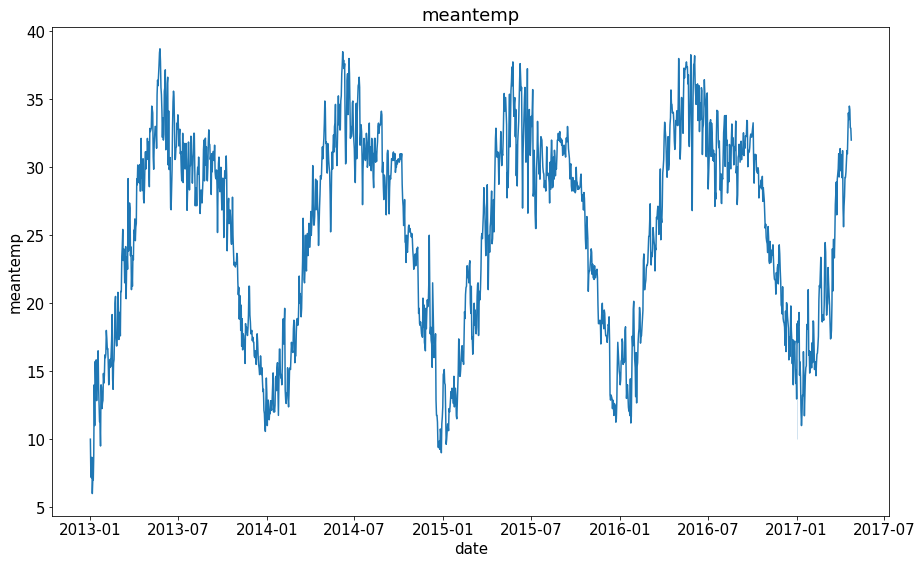

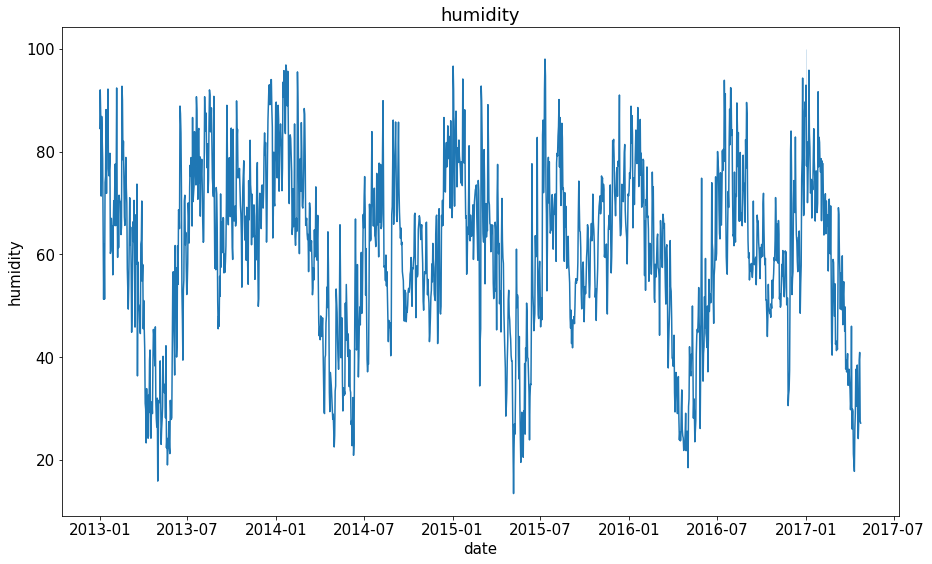

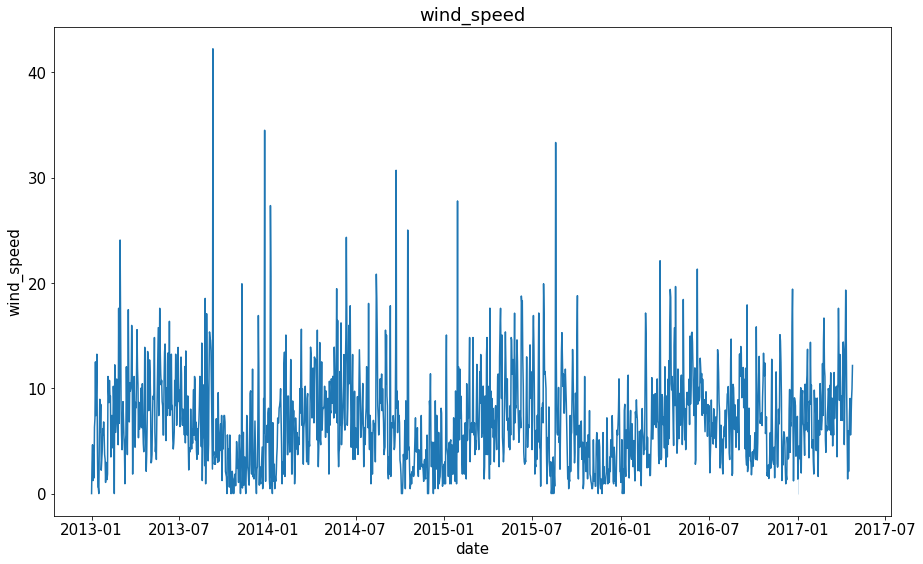

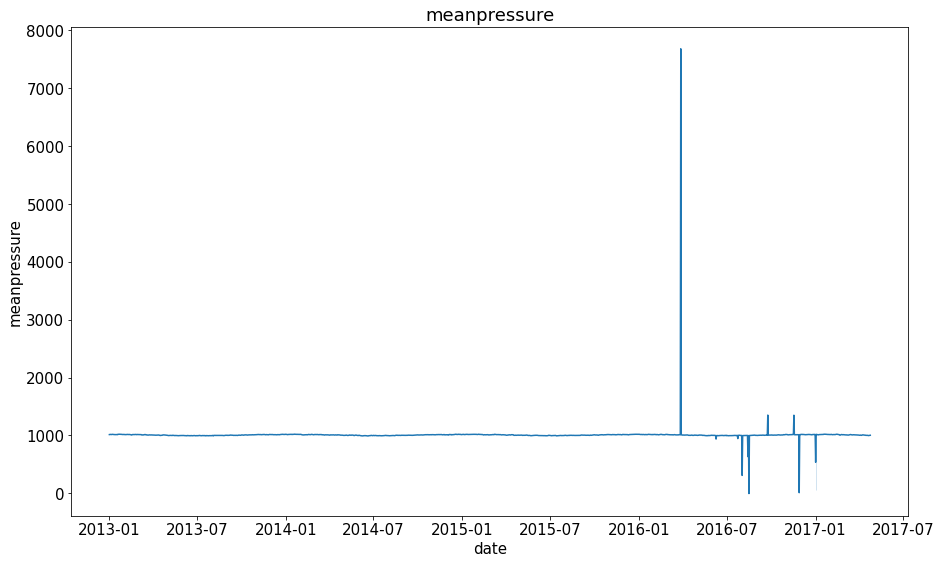

In [6]:
# Visualizing the behavior of all columns
columns = df.drop(columns=['date']).columns
for column in columns:
    sns.lineplot(x=df['date'], y=df[column])
    plt.title(column)
    plt.show()

All the columns look very stable, so this is good for us and our models!

In [7]:
# Function to convert our dataset in a time series dataset
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

The function above is simple, but very usefull. With it we can create our time series, varying the size of the window, offset and the feature we want for our new dataset

In [8]:
# scale all the dataset (not including the date)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='date'))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns='date').columns)

# Set the window to 10
window = 10
feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'meantemp']

# Create a window with all the columns as features (excluding the date)
feature, target = create_window(df_scaled['meantemp'],df_scaled[feature_columns], window=window)
print(feature[0])
print(target[0])
print(df_scaled.head(12))

[[ 1.41710331 -1.53000954  0.0289604  -2.07307279]
 [ 1.85893977 -0.8691521   0.04113786 -2.42716677]
 [ 1.56438213 -0.50250189  0.04608495 -2.45894443]
 [ 0.64143486 -1.25650031  0.03752267 -2.25465945]
 [ 1.55456354 -0.70948185  0.03371722 -2.61783275]
 [ 1.31695371 -1.20179846  0.04227949 -2.48164276]
 [ 1.06952529 -0.13289483  0.05369586 -2.48164276]
 [ 0.19258512  0.05402075  0.04635677 -2.2287185 ]
 [-0.54170499  1.24204346  0.03657131 -1.52831284]
 [ 0.09159393  0.11104584  0.0289604  -1.93688281]]
[-1.29484429]
    meantemp  humidity  wind_speed  meanpressure
0  -2.073073  1.417103   -1.530010      0.028960
1  -2.427167  1.858940   -0.869152      0.041138
2  -2.458944  1.564382   -0.502502      0.046085
3  -2.254659  0.641435   -1.256500      0.037523
4  -2.617833  1.554564   -0.709482      0.033717
5  -2.481643  1.316954   -1.201798      0.042279
6  -2.481643  1.069525   -0.132895      0.053696
7  -2.228718  0.192585    0.054021      0.046357
8  -1.528313 -0.541705    1.242043

Here we have our first time series, using all the columns and with a window of 10

In [9]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.9):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

Here we have a function to create the train and test dataset. We're using a custom function because we want to separate the dataset without any shuffle, just a clean cut, so we can maintain the temporal characteristic of the data

<AxesSubplot:xlabel='date'>

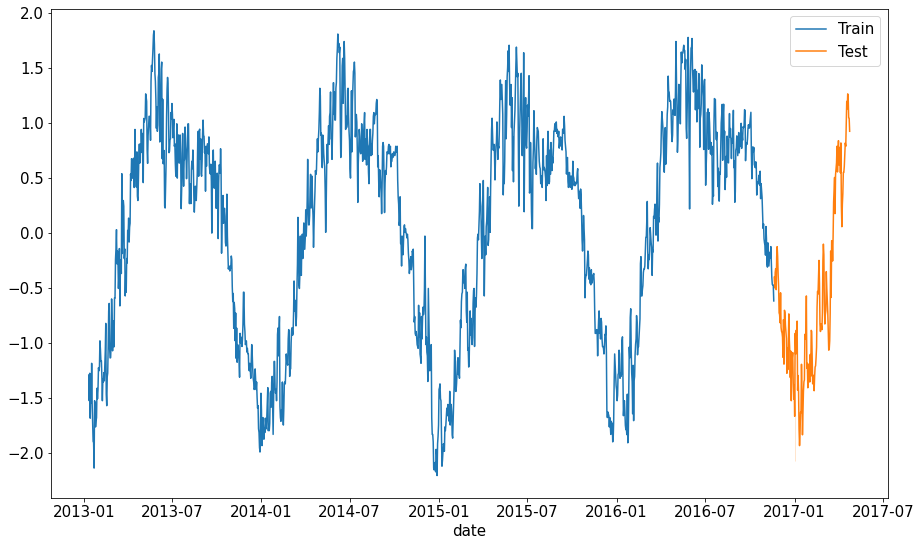

In [10]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

# 2. Prediction

In [11]:
# Create a standard model using LSTM
def model_lstm(x_shape):

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=(x_shape[1], x_shape[2])))
    model.add(keras.layers.Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model

We create a simple model because our dataset is not too complex, so a simple neural network will do

And we create this function because we use this same model after

## 2.1 Using all the features

To this case test we will use all the features on our time series

In [12]:
model = model_lstm(x_train.shape)
model.summary()

2022-06-30 14:08:02.892875: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [13]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50


2022-06-30 14:08:03.335518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


45/45 [==============================] - 3s 21ms/step - loss: 0.2240 - val_loss: 0.1849
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0812 - val_loss: 0.1334
Epoch 3/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.1435
Epoch 4/50
45/45 [==============================] - 1s 14ms/step - loss: 0.0656 - val_loss: 0.1037
Epoch 5/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0608 - val_loss: 0.1107
Epoch 6/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0579 - val_loss: 0.0977
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0562 - val_loss: 0.1138
Epoch 8/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0544 - val_loss: 0.0777
Epoch 9/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.1101
Epoch 10/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0514 - val_loss: 0.0857
Epoch 11/50
45/45 [=========

Based on the loss, our solution is pretty good!

In [14]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

# Function to print the y_predicted compared with the y_test
def print_test_x_prediction(y_test, y_predict, df_date, train_size, window=0):
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_test[:,0], label = 'Test')
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_predict[:,0], label = 'Predict')
    plt.show()

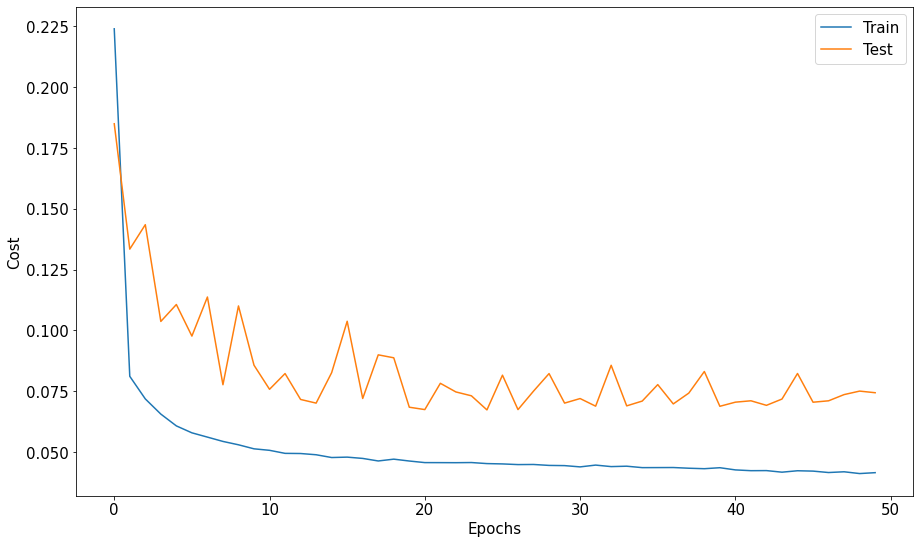

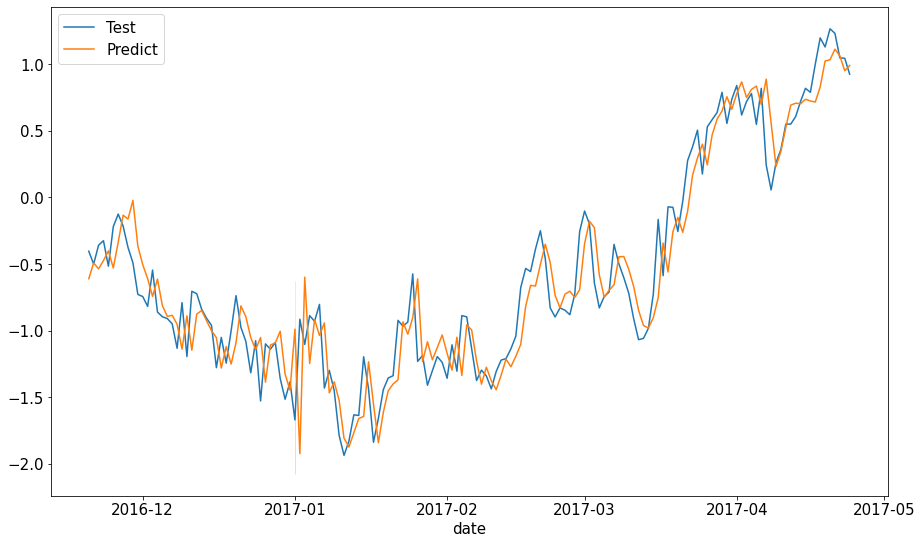

In [15]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

Well, looks like our model is very precise

## 2.2 Using only the target

Here we just will use the target value on our time series and ignore all the other features

In [16]:
feature, target = create_window(df_scaled['meantemp'], df_scaled[['meantemp']], window=10)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_lstm(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
45/45 [==============================] - 3s 18ms/step - loss: 0.1323 - val_loss: 0.1409
Epoch 2/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0816 - val_loss: 0.1458
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0748 - val_loss: 0.0868
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0681 - val_loss: 0.0864
Epoch 5/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0653 - val_loss: 0.0764
Epoch 6/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0624 - val_loss: 0.0760
Epoch 7/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0586 - val_loss: 0.0846
Epoch 8/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0560 - val_loss: 0.0679
Epoch 9/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0543 - val_loss: 0.0712
Epoch 10/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0528 - val_loss: 0.0646
Epoch 11/50
45/45 

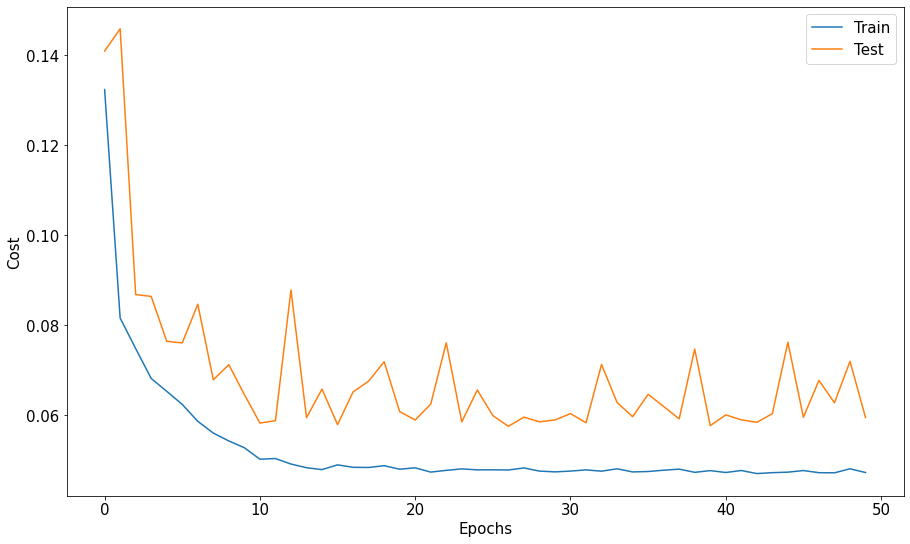

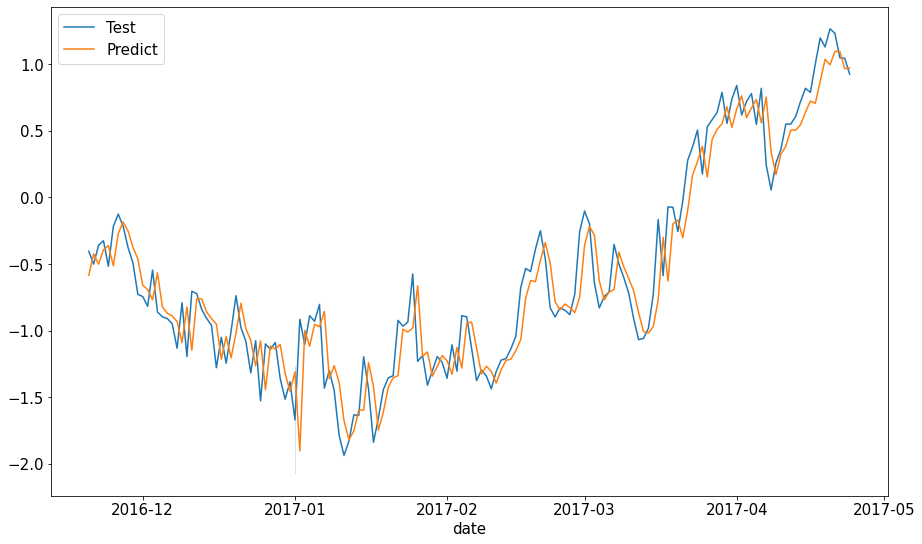

In [17]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

Looks like this solution had a better result than the last one, not for much, but it's a difference

This most likely happen because we have a simple dataset, and just the tempeture of the previous day is already enough to make a good prediction, the others features just confuse the model more than help, so less is more in this case!

In [18]:
# Create a dense neural network
def model_dense(x_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_dim=x_shape[1], activation=nn.relu))
    model.add(keras.layers.Dense(64,activation=nn.relu))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

This function is to create a simple dense neural network, so we can test against our lstm model we tested early

## 2.3 Not using time series

Here we don't use time series, just the features, and to help, the date separeted in month, year and day

In [19]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['date']))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns=['date']).columns)

feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'month', 'year', 'day']

feature, target = df_scaled[feature_columns], df_scaled['meantemp']

feature, target = np.array(feature), np.array(target).reshape(-1,1)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_dense(x_train.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [20]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
45/45 [==============================] - 1s 5ms/step - loss: 0.7507 - val_loss: 0.9503
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4529 - val_loss: 0.8581
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3106 - val_loss: 0.8313
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.2211 - val_loss: 0.7503
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1765 - val_loss: 0.5711
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.1353 - val_loss: 0.6826
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1201 - val_loss: 0.5179
Epoch 8/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1015 - val_loss: 0.5384
Epoch 9/50
45/45 [==============================] - 0s 2ms/step - loss: 0.1020 - val_loss: 0.3971
Epoch 10/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0998 - val_loss: 0.3813
Epoch 11/50
45/45 [

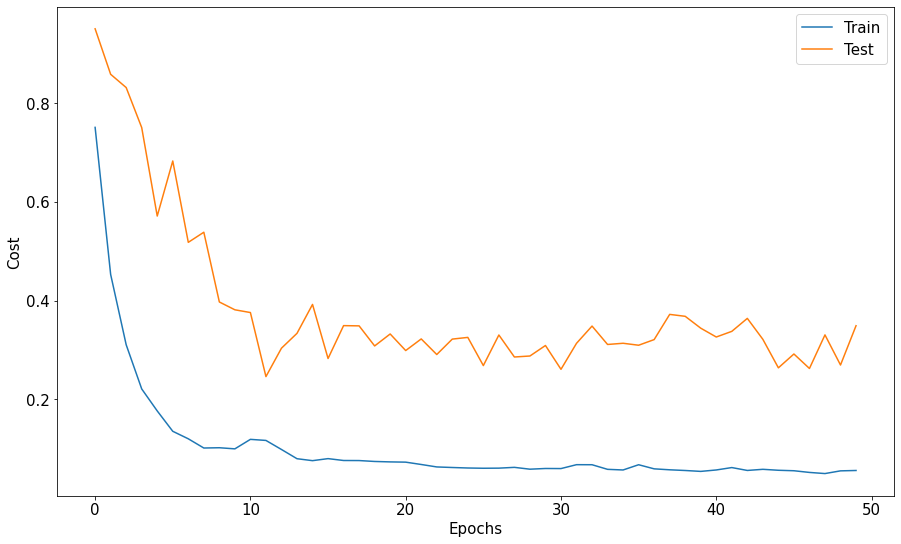

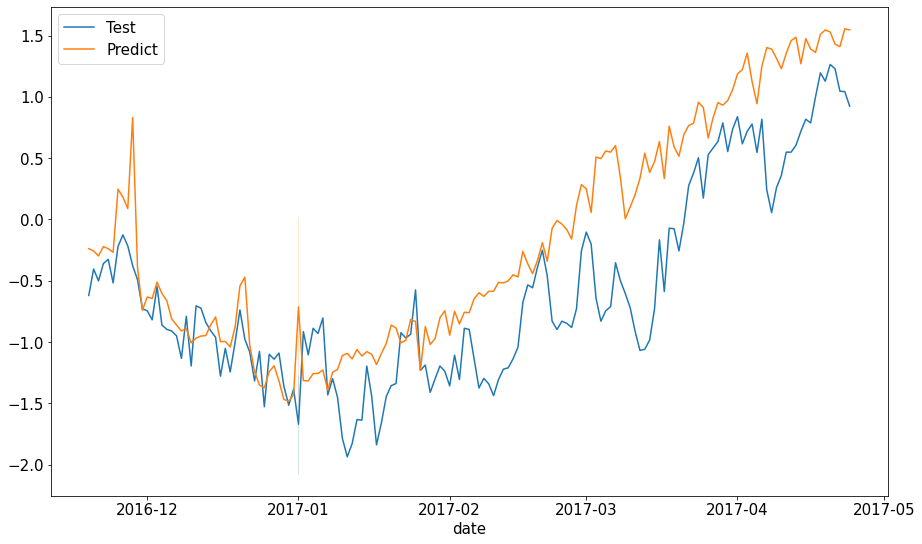

In [21]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=0)

Well, is not a bad result, but nothing compared with the previous ones. This shows the power of time series for forecasting

## 2.4 Using time series, but not with LSTM

Here we gonna use time series, but in our dense model, to see if LSTM is the one that creates the good results, or is the dataset itself

In [22]:
feature, target = create_window(df_scaled['meantemp'], df_scaled[['meantemp']], window=10)

feature = feature.reshape(-1, feature.shape[1] * feature.shape[2])
x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_dense(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
45/45 [==============================] - 1s 5ms/step - loss: 0.2742 - val_loss: 0.1022
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0937 - val_loss: 0.0716
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0783 - val_loss: 0.0656
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0646
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0651
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0662 - val_loss: 0.0622
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0715
Epoch 8/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss: 0.0627
Epoch 9/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0573 - val_loss: 0.0729
Epoch 10/50
45/45 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0608
Epoch 11/50
45/45 [

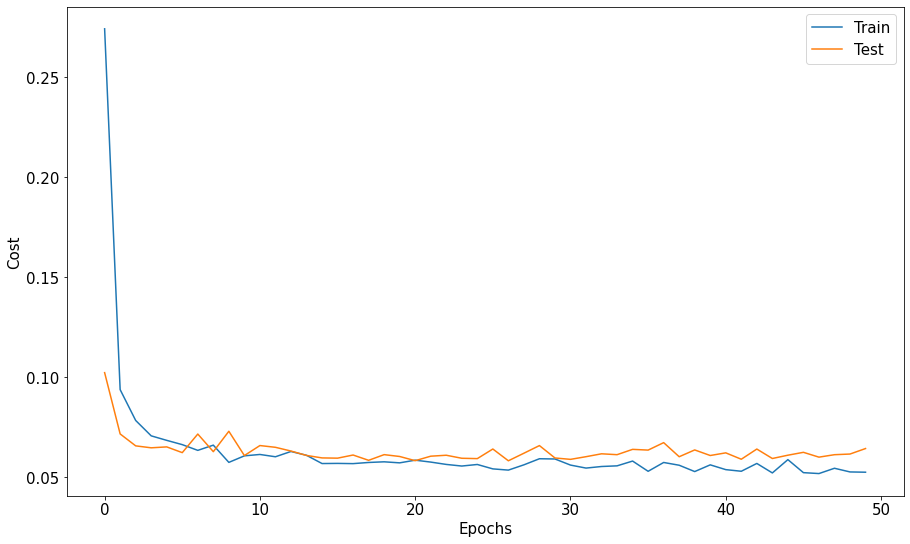

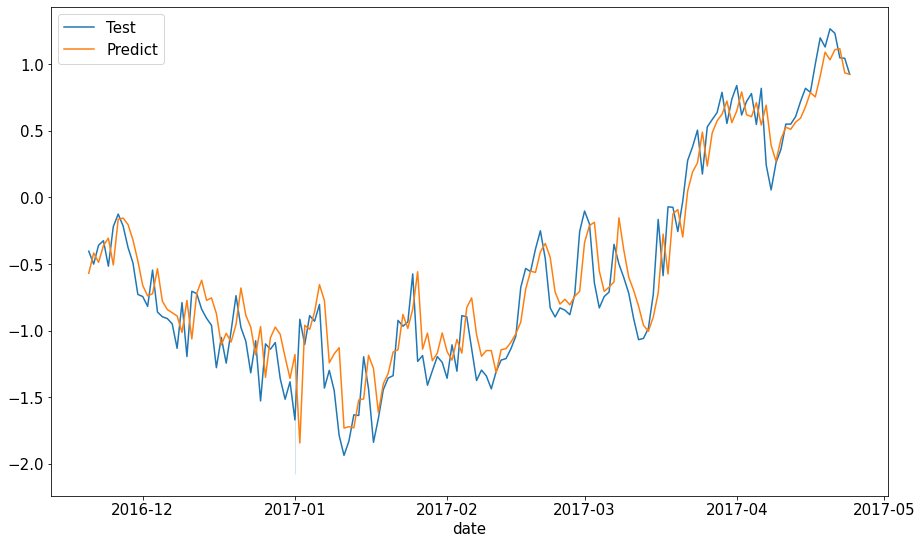

In [23]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

Wow, great result, and without LSTM, this shows us that time series is more a concept than a specific algorithm, like LSTM or GRU

## 2.5 Time Series with Linear Regression

And to reinforce the previous idea, lets test with a simple Linear Regression and see the result

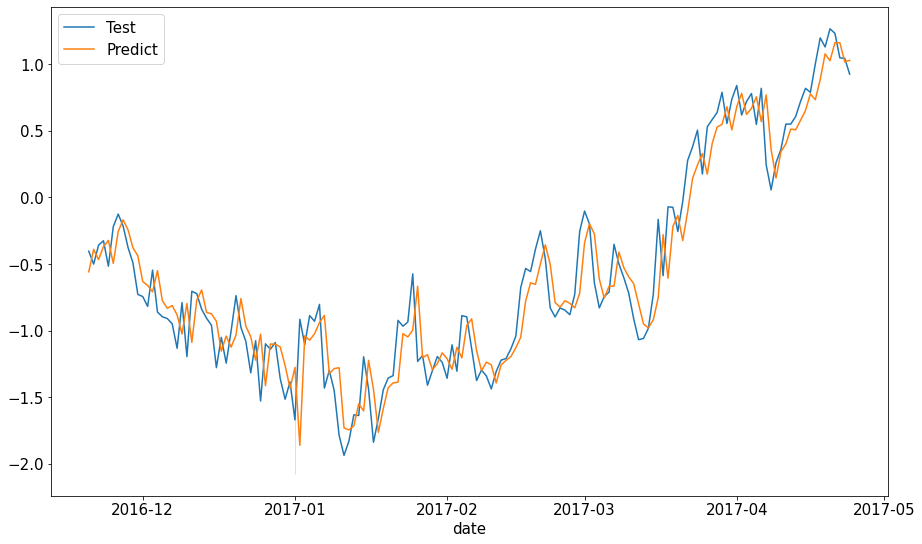

In [24]:
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression().fit(x_train, y_train)
y_predict = model_linear_reg.predict(x_test)

print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

Well, i think this proves that time series are very powerful even when not used with their most well know alghoritm

# 3. Conclusion

Well this concludes this notebook, any suggestions or tips are always welcome!